In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('IT.csv', index_col=['date'])
prices.head(10)

INFY.NS       TCS.NS  HCLTECH.NS    WIPRO.NS    TECHM.NS  \
date                                                                      
01-01-2018  516.775024  1322.800049  439.350006  237.412552  503.100006   
02-01-2018  514.849976  1315.599976  446.399994  239.025055  513.950012   
03-01-2018  510.649994  1319.324951  448.649994  232.462555  519.450012   
04-01-2018  507.700012  1328.550049  446.549988  233.737564  522.549988   
05-01-2018  506.000000  1344.599976  450.024994  232.162552  525.450012   
08-01-2018  518.025024  1357.199951  450.250000  233.362564  536.299988   
09-01-2018  520.674988  1354.500000  446.924988  237.900055  533.849976   
10-01-2018  526.125000  1403.300049  457.924988  245.025055  542.099976   
11-01-2018  537.900024  1395.250000  458.450012  240.825058  551.700012   
12-01-2018  539.224976  1388.175049  462.950012  239.100052  550.750000   

                 LTI.NS  MINDTREE.NS  MPHASIS.NS  COFORGE.NS      LTTS.NS  
date                                                                       
01-01-2018  1145.400024   606.900024  738.250000  653.799988  1073.449951  
02-01-2018  1149.000000   605.049988  734.650024  642.549988  1105.550049  
03-01-2018  1124.800049   599.299988  720.049988  645.950012  1137.750000  
04-01-2018  1130.550049   599.900024  715.849976  653.150024  1137.900024  
05-01-2018  1108.500000   602.299988  714.000000  669.500000  1128.250000  
08-01-2018  1118.050049   632.650024  715.599976  704.049988  1111.349976  
09-01-2018  1109.050049   626.049988  712.349976  689.900024  1082.650024  
10-01-2018  1112.900024   623.849976  710.000000  719.150024  1075.300049  
11-01-2018  1118.099976   621.200012  716.200012  717.650024  1054.900024  
12-01-2018  1124.650024   633.750000  728.599976  701.299988  1043.800049

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

INFY.NS       TCS.NS  HCLTECH.NS    WIPRO.NS    TECHM.NS  \
date                                                                       
01-01-2018   516.775024  1322.800049  439.350006  237.412552  503.100006   
02-01-2018   514.849976  1315.599976  446.399994  239.025055  513.950012   
30-12-2020  1246.800049  2909.300049  940.700012  384.399994  983.250000   
31-12-2020  1255.800049  2862.750000  946.150024  386.250000  973.200012   

                 LTI.NS  MINDTREE.NS   MPHASIS.NS   COFORGE.NS      LTTS.NS  
date                                                                         
01-01-2018  1145.400024   606.900024   738.250000   653.799988  1073.449951  
02-01-2018  1149.000000   605.049988   734.650024   642.549988  1105.550049  
30-12-2020  3661.149902  1629.949951  1590.400024  2694.600098  2338.649902  
31-12-2020  3659.500000  1660.349976  1539.949951  2705.149902  2339.600098

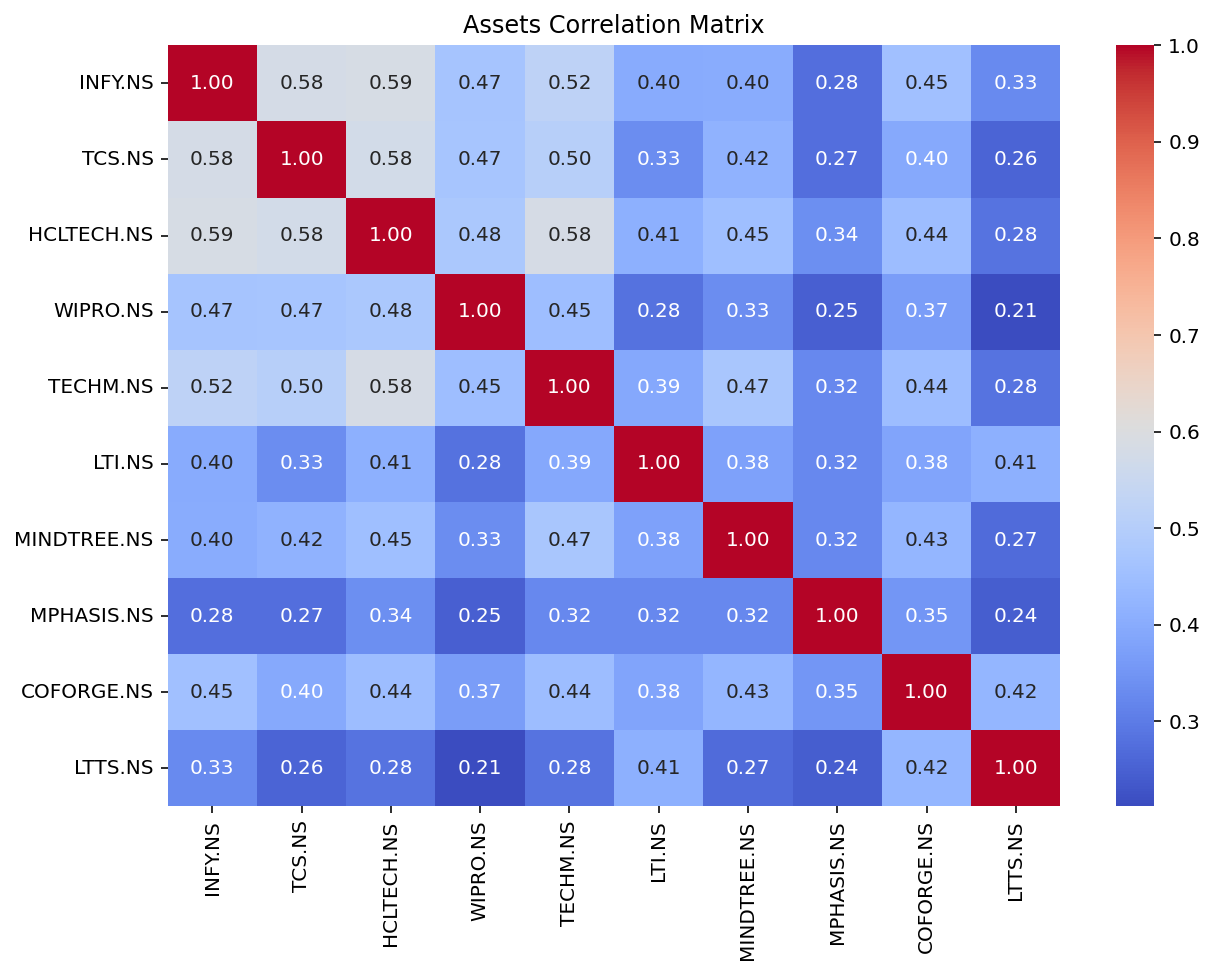

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('INFY.NS', 'HCLTECH.NS'), ('TCS.NS', 'WIPRO.NS'), ('TCS.NS', 'COFORGE.NS'), ('HCLTECH.NS', 'LTI.NS'), ('WIPRO.NS', 'LTTS.NS'), ('TECHM.NS', 'LTTS.NS')]


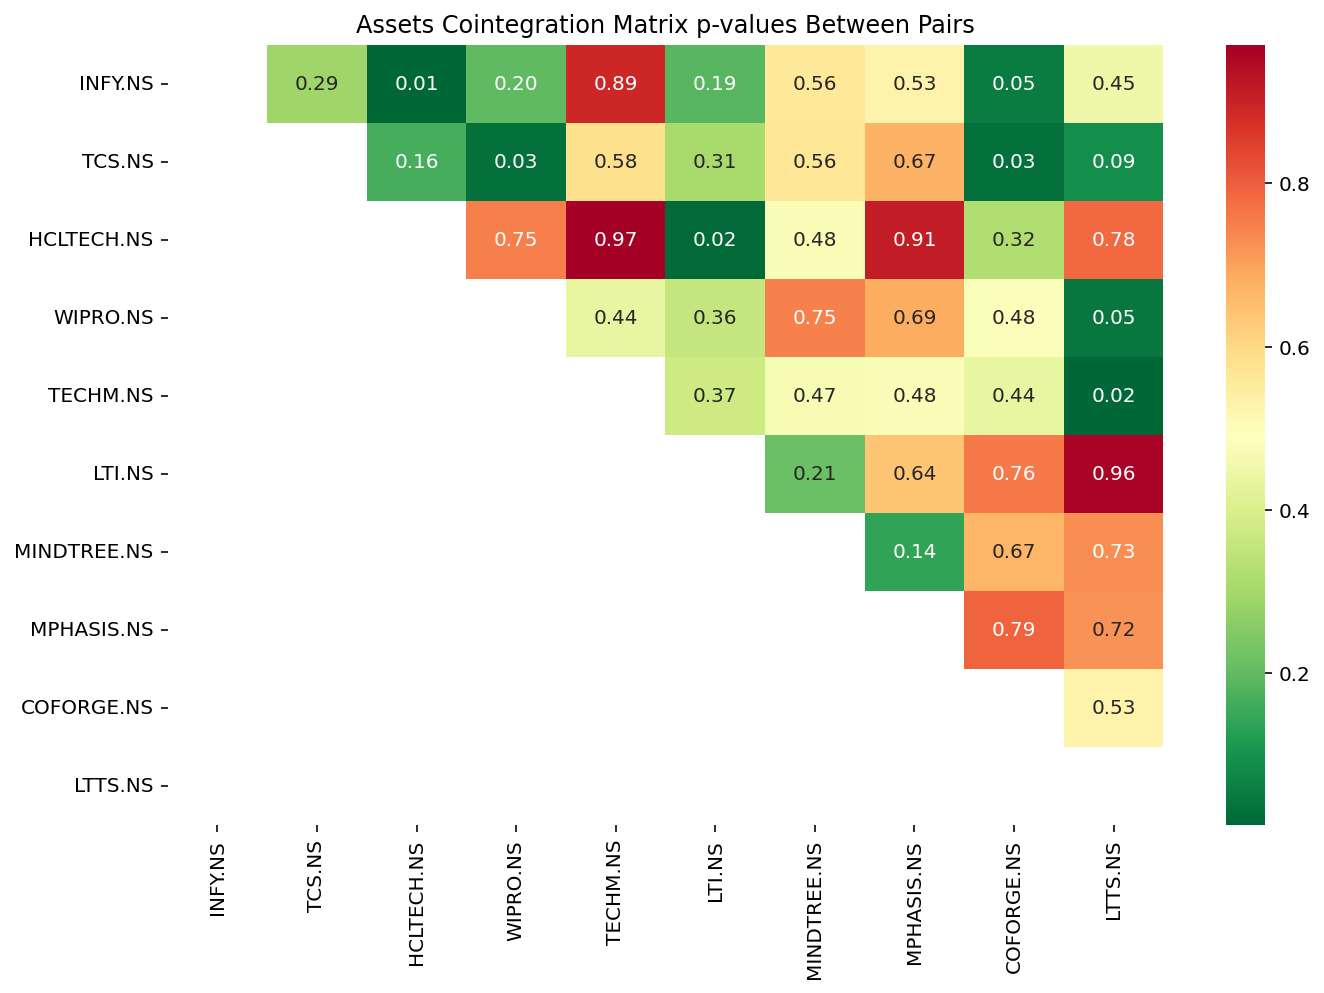

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'HCLTECH.NS'
asset2 = 'LTI.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

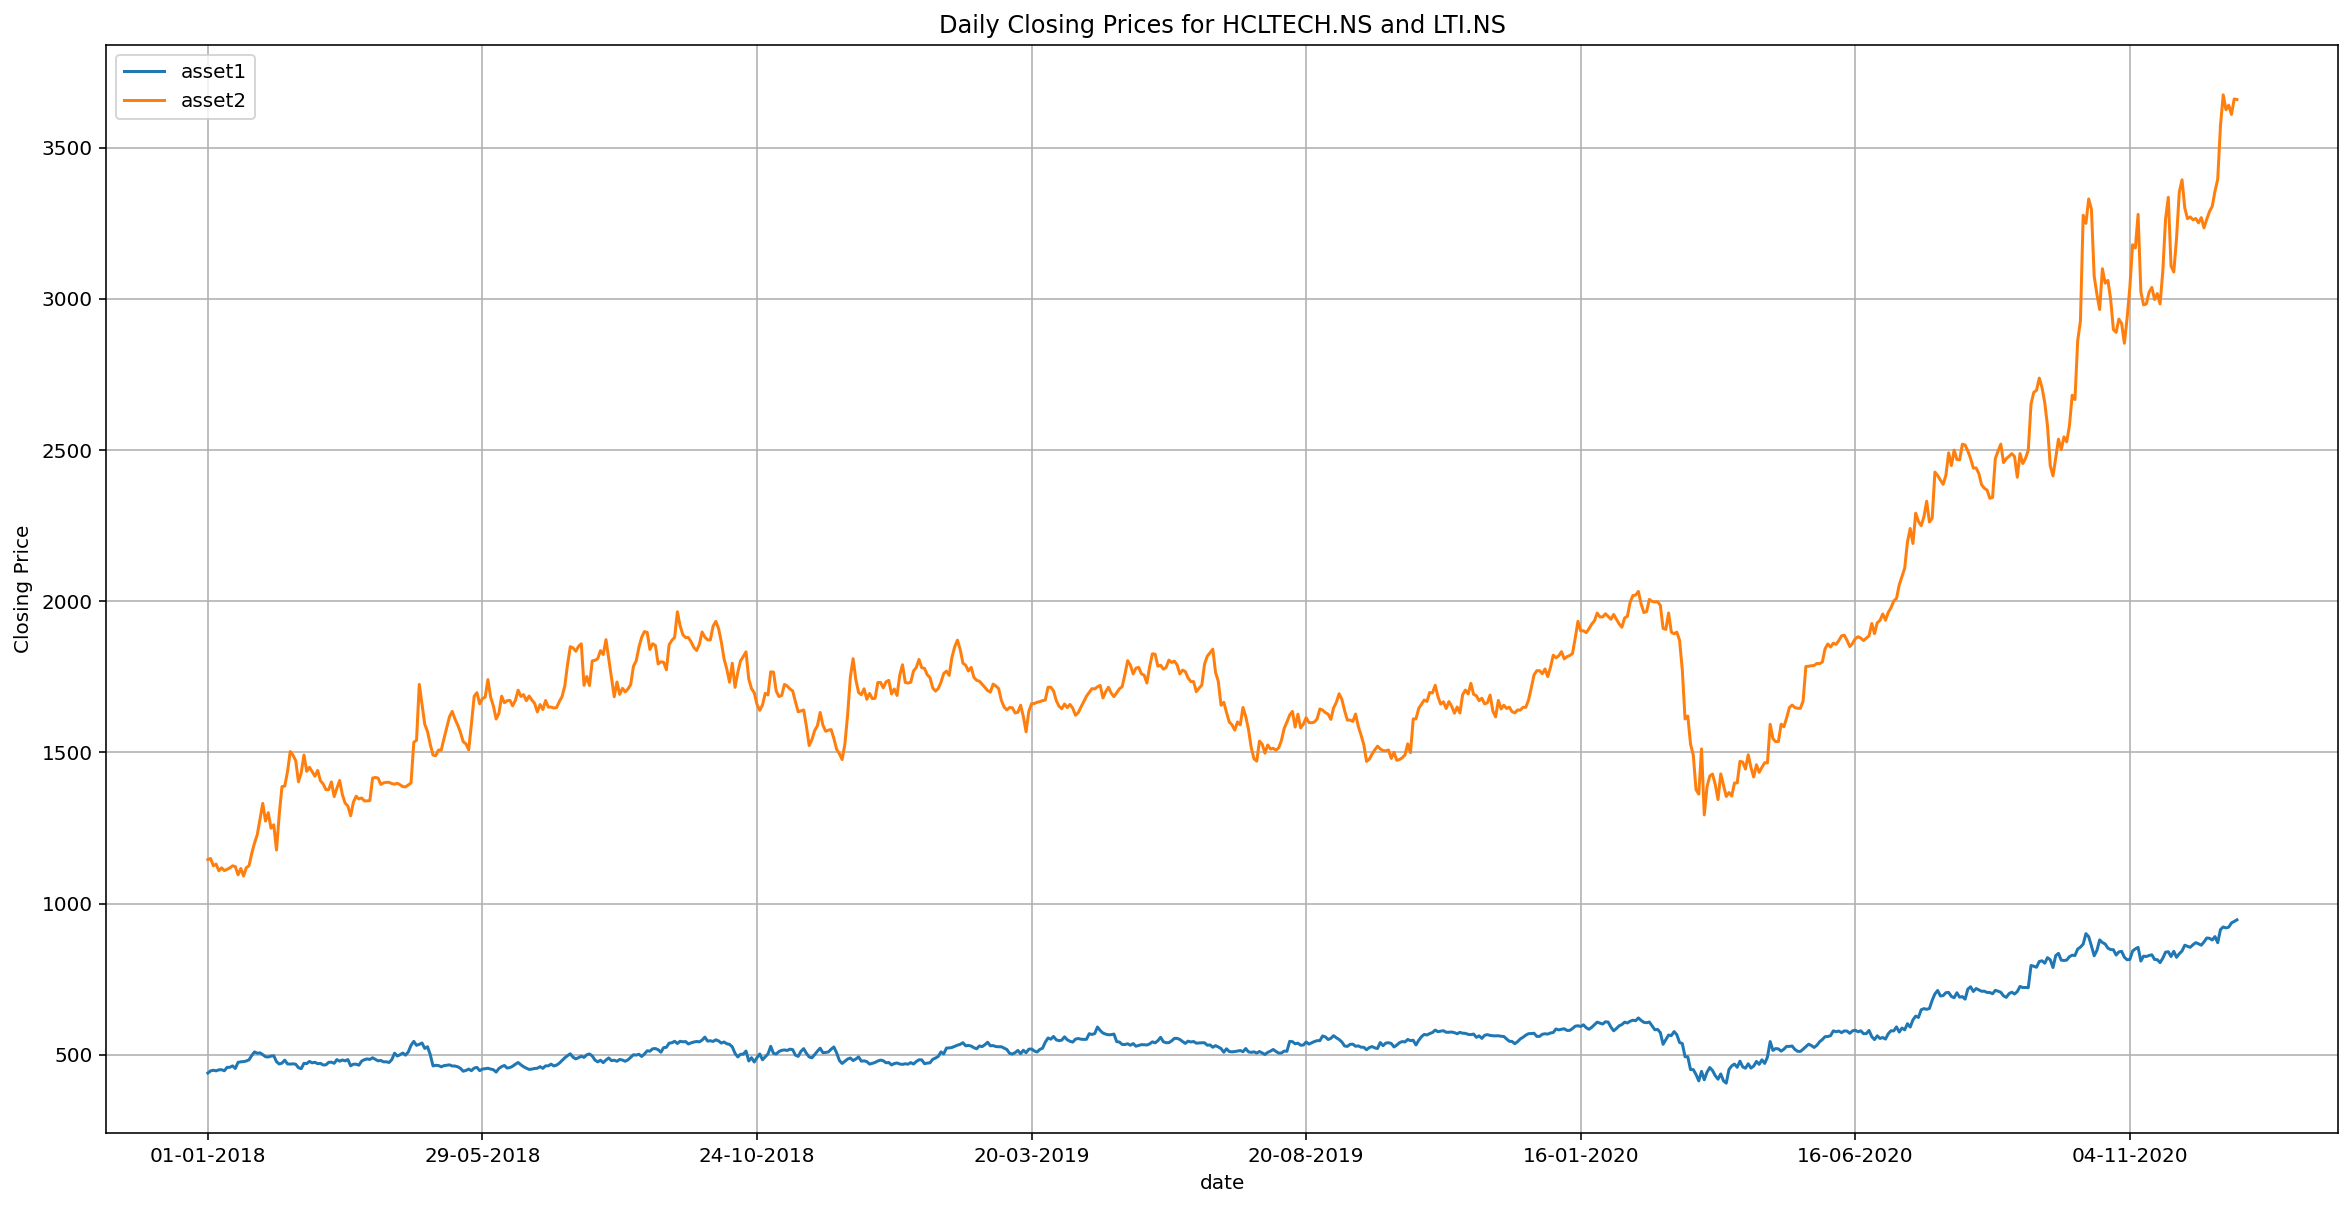

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          7.637e+04
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        11:32:52   Log-Likelihood:                         -4921.7
No. Observations:                 740   AIC:                                      9845.
Df Residuals:                     739   BIC:                                      9850.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         3.3174      0.012    276.347      0.000       3.294       3.341
==============================================================================
Omnibus:                       28.300   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.893
Skew:                           0.422   Prob(JB):                     7.20e-08
Kurtosis:                       3.595   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

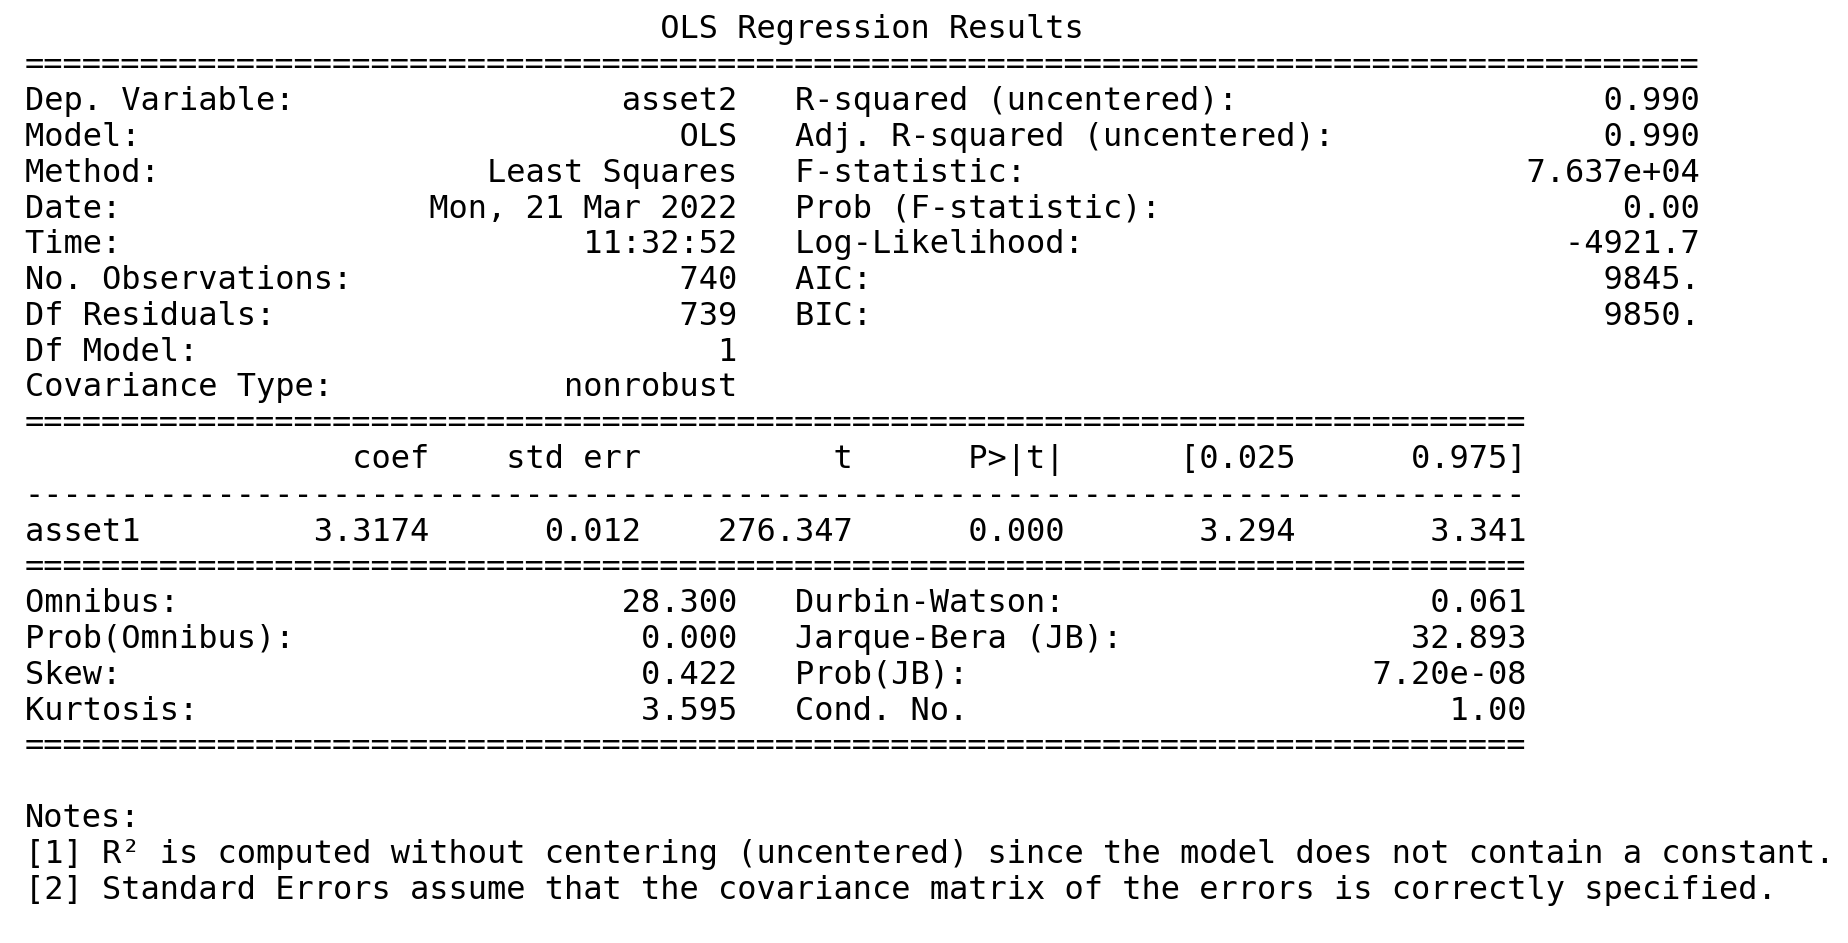

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  3.31736431302867


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

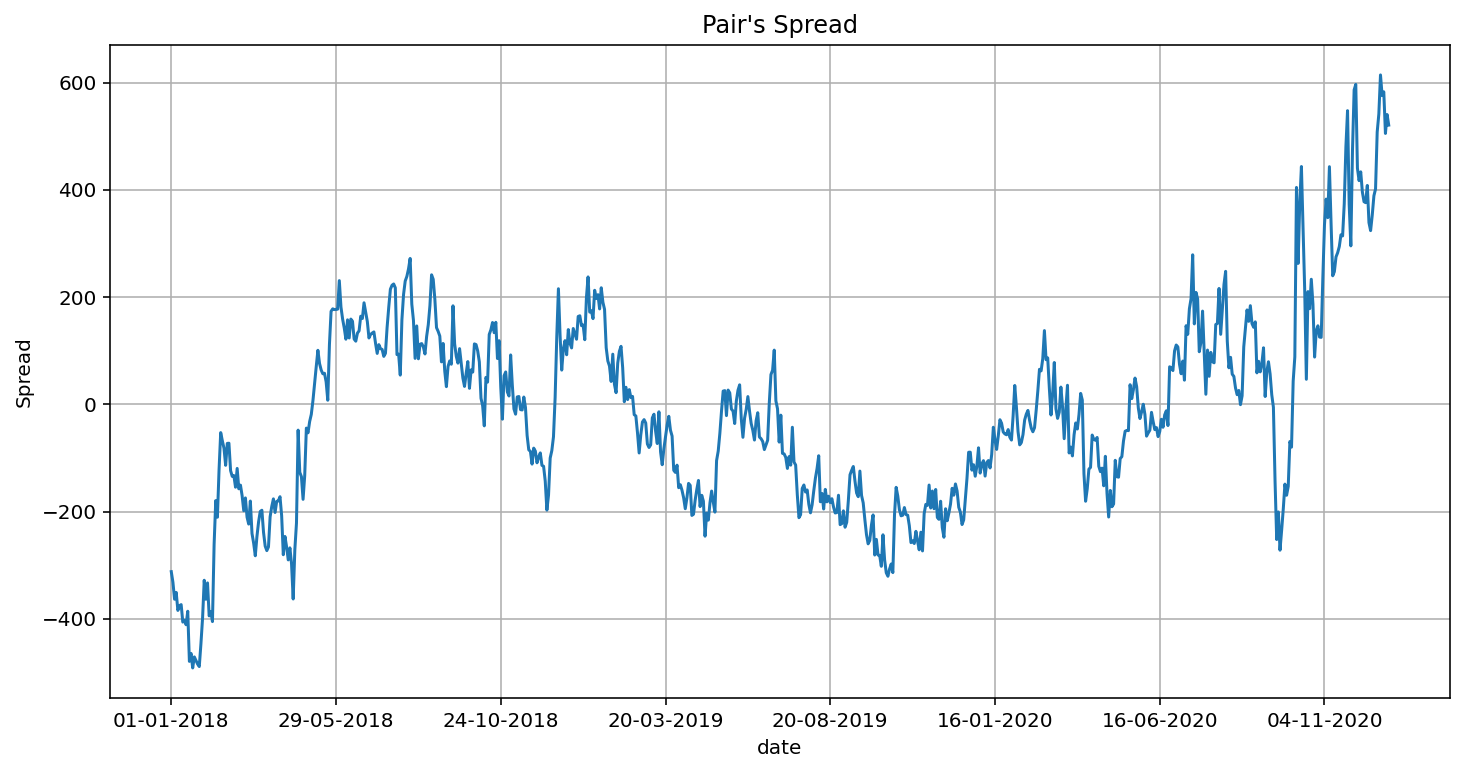

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-2.9566034539198385,
 0.03915066928093255,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 7745.055401760407)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -2.9566034539198385


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1       asset2
date                               
01-01-2021  950.500000  3699.300049
04-01-2021  980.400024  3845.350098
05-01-2021  991.349976  4129.350098
06-01-2021  978.200012  3956.899902
07-01-2021  962.549988  3882.899902

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1       asset2         z  z upper limit  z lower limit
date                                                                       
01-01-2021  950.500000  3699.300049  1.229231            1.0           -1.0
04-01-2021  980.400024  3845.350098  1.158436            1.0           -1.0
05-01-2021  991.349976  4129.350098  0.627150            1.0           -1.0
06-01-2021  978.200012  3956.899902  0.882014            1.0           -1.0
07-01-2021  962.549988  3882.899902  0.906320            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

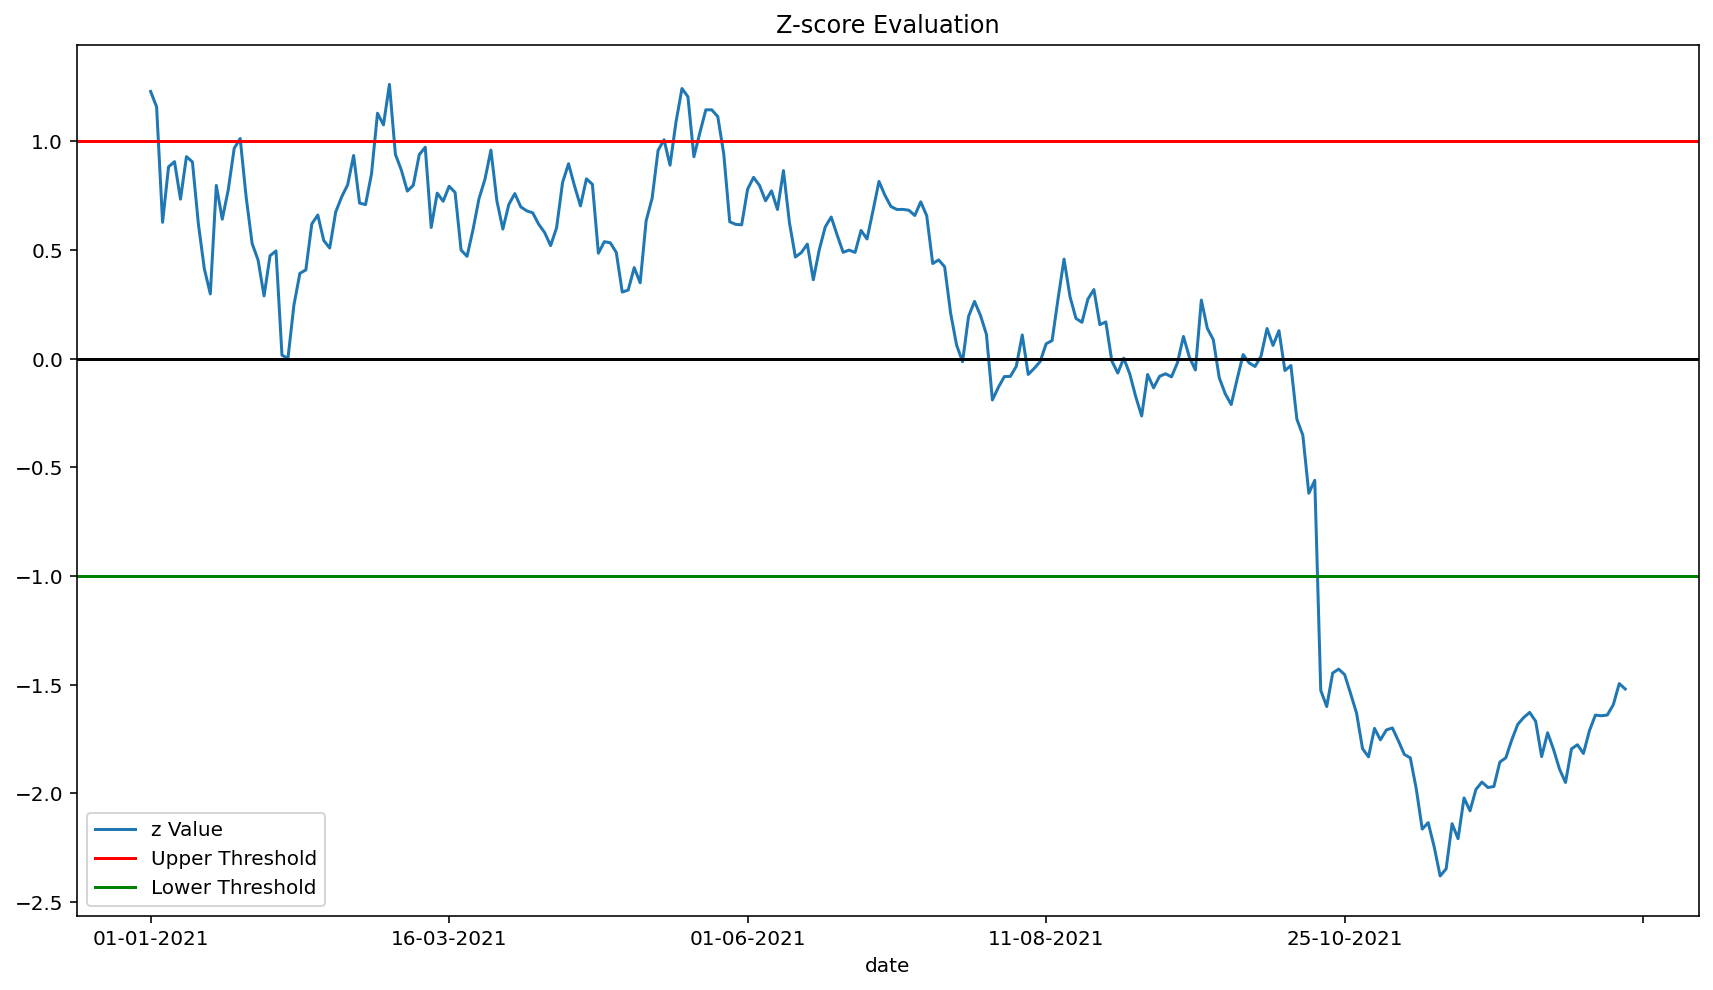

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021   950.500000  3699.300049  1.229231            1.0           -1.0   
04-01-2021   980.400024  3845.350098  1.158436            1.0           -1.0   
05-01-2021   991.349976  4129.350098  0.627150            1.0           -1.0   
29-12-2021  1291.900024  7263.100098 -1.593294            1.0           -1.0   
30-12-2021  1317.050049  7292.500000 -1.495782            1.0           -1.0   
31-12-2021  1319.099976  7332.000000 -1.520534            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021         0         1.0         0        -1.0  
29-12-2021         1         0.0        -1         0.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  950.500000  3699.300049  1.229231            1.0           -1.0   
04-01-2021  980.400024  3845.350098  1.158436            1.0           -1.0   
22-01-2021  985.799988  3929.449951  1.012704            1.0           -1.0   
25-02-2021  929.250000  3656.500000  1.129136            1.0           -1.0   
26-02-2021  909.450012  3599.850098  1.075556            1.0           -1.0   
01-03-2021  930.349976  3608.050049  1.261839            1.0           -1.0   
11-05-2021  907.299988  3618.850098  1.006999            1.0           -1.0   
14-05-2021  910.349976  3598.350098  1.088244            1.0           -1.0   
17-05-2021  922.150024  3583.649902  1.242830            1.0           -1.0   
18-05-2021  931.599976  3635.399902  1.204865            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
22-01-2021        -1        -1.0         1         1.0  
25-02-2021        -1        -1.0         1         1.0  
26-02-2021        -1         0.0         1         0.0  
01-03-2021        -1         0.0         1         0.0  
11-05-2021        -1        -1.0         1         1.0  
14-05-2021        -1        -1.0         1         1.0  
17-05-2021        -1         0.0         1         0.0  
18-05-2021        -1         0.0         1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021   950.500000  3699.300049  1.229231            1.0           -1.0   
05-01-2021   991.349976  4129.350098  0.627150            1.0           -1.0   
22-01-2021   985.799988  3929.449951  1.012704            1.0           -1.0   
25-01-2021   947.500000  3893.850098  0.743463            1.0           -1.0   
25-02-2021   929.250000  3656.500000  1.129136            1.0           -1.0   
14-05-2021   910.349976  3598.350098  1.088244            1.0           -1.0   
19-05-2021   931.400024  3747.699951  0.928850            1.0           -1.0   
20-05-2021   924.400024  3673.750000  1.039412            1.0           -1.0   
26-05-2021   945.799988  3799.850098  0.942371            1.0           -1.0   
19-10-2021  1232.099976  6855.149902 -1.526834            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
05-01-2021         0         1.0         0        -1.0  
22-01-2021        -1        -1.0         1         1.0  
25-01-2021         0         1.0         0        -1.0  
25-02-2021        -1        -1.0         1         1.0  
14-05-2021        -1        -1.0         1         1.0  
19-05-2021         0         1.0         0        -1.0  
20-05-2021        -1        -1.0         1         1.0  
26-05-2021         0         1.0         0        -1.0  
19-10-2021         1         1.0        -1        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

991.349976     1
947.500000     1
953.750000     1
906.099976     1
931.400024     1
945.799988     1
1232.099976    1
Name: asset1, dtype: int64

In [32]:
signals

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021   950.500000  3699.300049  1.229231            1.0           -1.0   
04-01-2021   980.400024  3845.350098  1.158436            1.0           -1.0   
05-01-2021   991.349976  4129.350098  0.627150            1.0           -1.0   
06-01-2021   978.200012  3956.899902  0.882014            1.0           -1.0   
07-01-2021   962.549988  3882.899902  0.906320            1.0           -1.0   
...                 ...          ...       ...            ...            ...   
27-12-2021  1267.199951  7181.250000 -1.643705            1.0           -1.0   
28-12-2021  1283.900024  7271.950195 -1.640293            1.0           -1.0   
29-12-2021  1291.900024  7263.100098 -1.593294            1.0           -1.0   
30-12-2021  1317.050049  7292.500000 -1.495782            1.0           -1.0   
31-12-2021  1319.099976  7332.000000 -1.520534            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021         0         1.0         0        -1.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021         1         0.0        -1         0.0  
28-12-2021         1         0.0        -1         0.0  
29-12-2021         1         0.0        -1         0.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

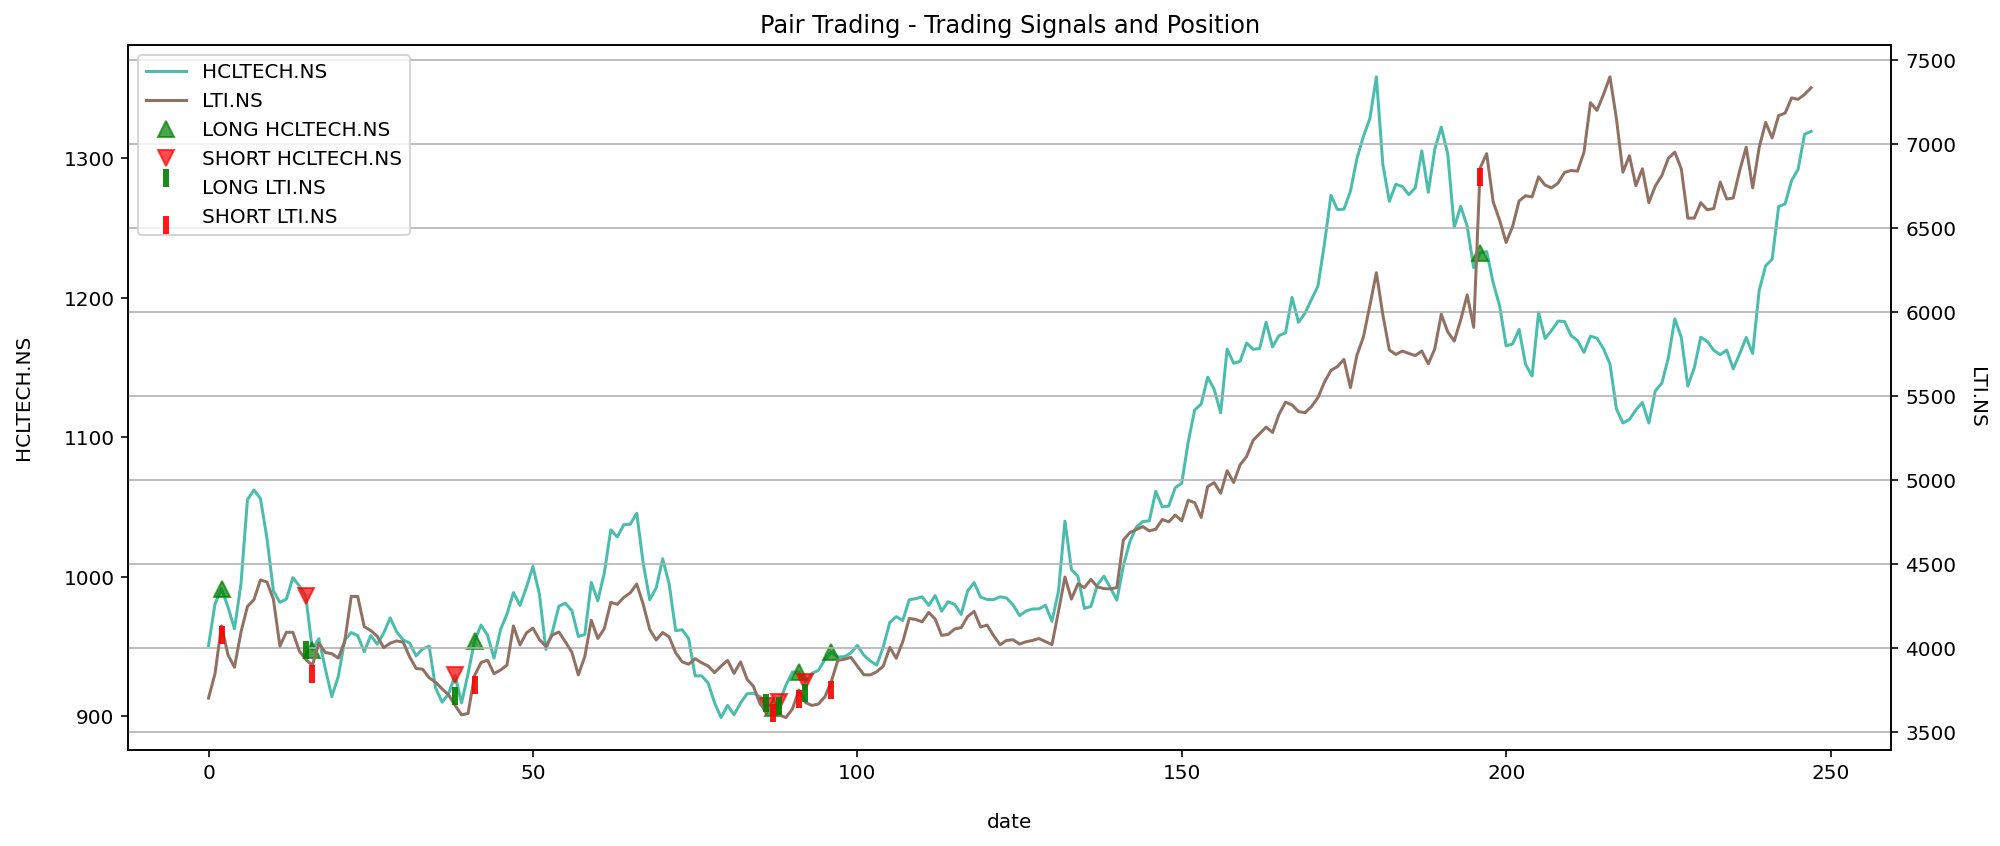

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0     950.500000            NaN            NaN            NaN       NaN   
1     980.400024       0.000000  100000.000000  100000.000000       NaN   
2     991.349976   72368.548219   27631.451781  100000.000000  0.000000   
3     978.200012   71408.600891   27631.451781   99040.052672 -0.009599   
4     962.549988   70266.149109   27631.451781   97897.600891 -0.011535   
243  1267.199951  185011.192846  -64315.697357  120695.495489  0.002425   
244  1283.900024  187449.403504  -64315.697357  123133.706147  0.020201   
245  1291.900024  188617.403504  -64315.697357  124301.706147  0.009486   
246  1317.050049  192289.307154  -64315.697357  127973.609797  0.029540   
247  1319.099976  192588.596496  -64315.697357  128272.899139  0.002339   

     positions1  
0           NaN  
1           0.0  
2           1.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1         cash1   total asset1   return1  \
0   950.500000           NaN           NaN            NaN       NaN   
2   991.349976  72368.548219  27631.451781  100000.000000  0.000000   
15  985.799988      0.000000  99594.850891   99594.850891 -0.005467   
16  947.500000  69167.500000  30427.350891   99594.850891  0.000000   
38  929.250000      0.000000  98262.600891   98262.600891  0.009941   

    positions1  
0          NaN  
2          1.0  
15        -1.0  
16         1.0  
38        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0     950.500000            NaN            NaN            NaN       NaN   
1     980.400024       0.000000  100000.000000  100000.000000       NaN   
2     991.349976   72368.548219   27631.451781  100000.000000  0.000000   
3     978.200012   71408.600891   27631.451781   99040.052672 -0.009599   
4     962.549988   70266.149109   27631.451781   97897.600891 -0.011535   
243  1267.199951  185011.192846  -64315.697357  120695.495489  0.002425   
244  1283.900024  187449.403504  -64315.697357  123133.706147  0.020201   
245  1291.900024  188617.403504  -64315.697357  124301.706147  0.009486   
246  1317.050049  192289.307154  -64315.697357  127973.609797  0.029540   
247  1319.099976  192588.596496  -64315.697357  128272.899139  0.002339   

     positions1       asset2      holdings2          cash2   total asset2  \
0           NaN  3699.300049            NaN            NaN            NaN   
1           0.0  3845.350098       0.000000  100000.000000  100000.000000   
2           1.0  4129.350098  -53681.551274  153681.551274  100000.000000   
3           0.0  3956.899902  -51439.698726  153681.551274  102241.852548   
4           0.0  3882.899902  -50477.698726  153681.551274  103203.852548   
243         0.0  7181.250000 -186712.500000  248769.400637   62056.900637   
244         0.0  7271.950195 -189070.705070  248769.400637   59698.695567   
245         0.0  7263.100098 -188840.602548  248769.400637   59928.798089   
246         0.0  7292.500000 -189605.000000  248769.400637   59164.400637   
247         0.0  7332.000000 -190632.000000  248769.400637   58137.400637   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000        -1.0  
3    0.022419         0.0  
4    0.009409         0.0  
243 -0.006121         0.0  
244 -0.038001         0.0  
245  0.003854         0.0  
246 -0.012755         0.0  
247 -0.017358         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1         cash1   total asset1   return1  \
0   950.500000           NaN           NaN            NaN       NaN   
2   991.349976  72368.548219  27631.451781  100000.000000  0.000000   
15  985.799988      0.000000  99594.850891   99594.850891 -0.005467   
16  947.500000  69167.500000  30427.350891   99594.850891  0.000000   
38  929.250000      0.000000  98262.600891   98262.600891  0.009941   

    positions1       asset2     holdings2          cash2   total asset2  \
0          NaN  3699.300049           NaN            NaN            NaN   
2          1.0  4129.350098 -53681.551274  153681.551274  100000.000000   
15        -1.0  3929.449951      0.000000  102598.701911  102598.701911   
16         1.0  3893.850098 -50620.051274  153218.753185  102598.701911   
38        -1.0  3656.500000      0.000000  105684.253185  105684.253185   

         return2  positions2  
0            NaN         NaN  
2   0.000000e+00        -1.0  
15  6.362942e-03         1.0  
16 -1.110223e-16        -1.0  
38  7.716329e-03         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

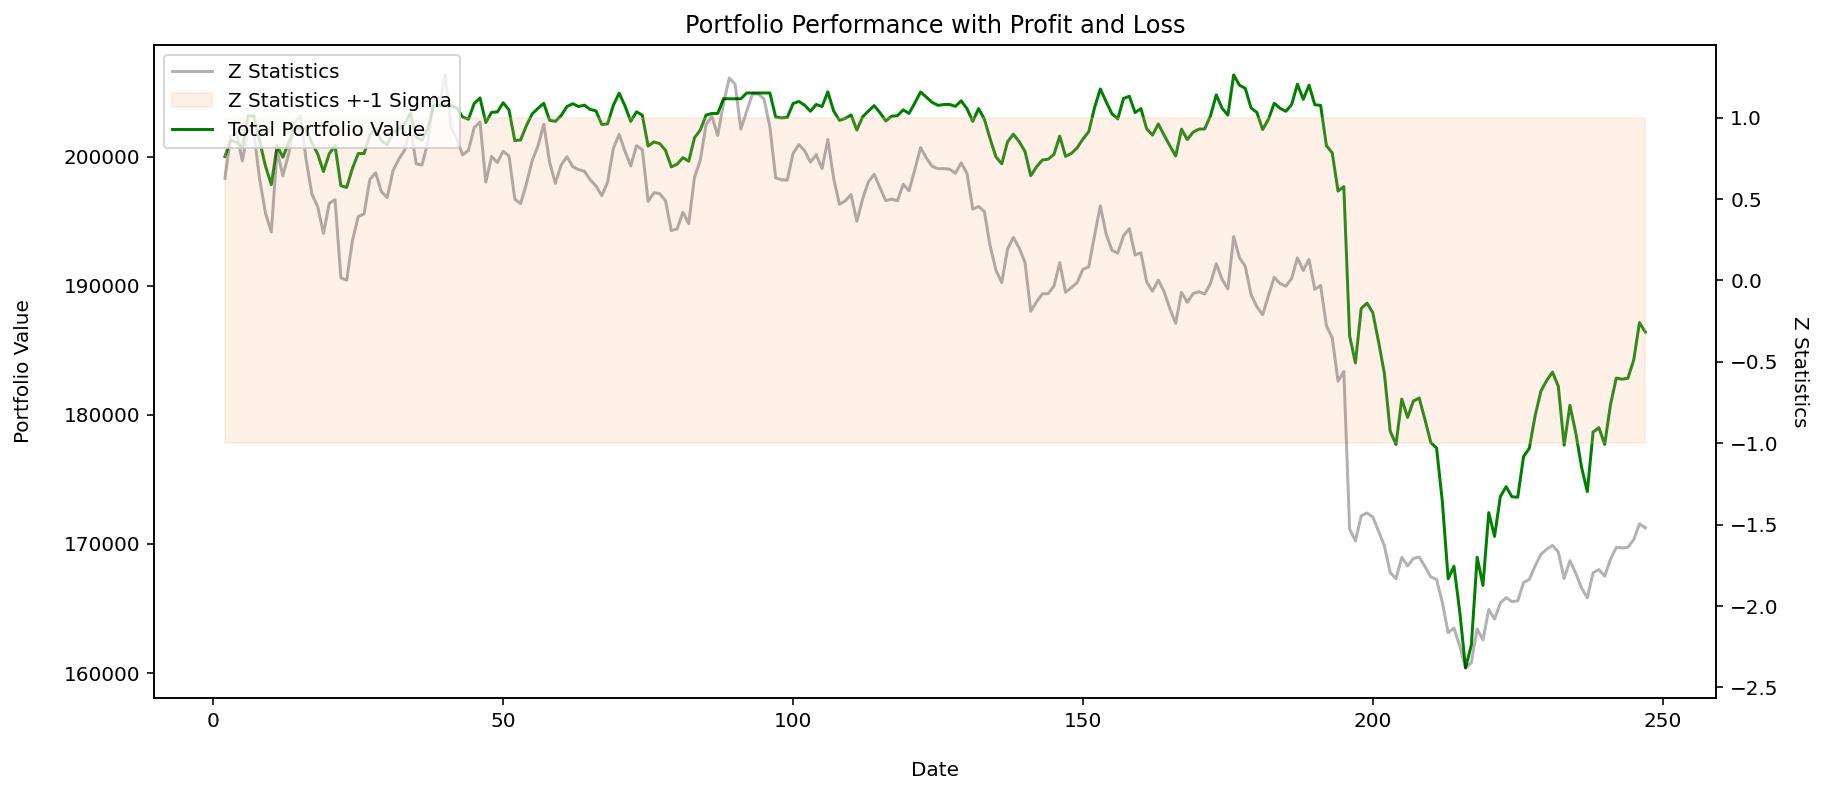

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

186410.2997756

In [48]:
profit = final_portfolio - 2*initial_capital
profit

-13589.700224400003

In [49]:
roi = (profit/(2*initial_capital))*100
roi

-6.794850112200002

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 152.898%
